# First Project in DataScience:
## Predicting housing prices with linear regression and random forests.

The following script attempts to predict the sale price of houses based on a detailed data set of house sales from Ames, Iowa. The data set can be found here:
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

My intention with this script is to familiarize myelf with the following:

- Jupyter/iPython Notebooks
- Pandas and Data science tools in python
- working with large, real-world data sets

In [1]:
# Load relevant packages

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import style

# cell magick to show plots within the cell
%matplotlib inline

# configures plot style
style.use('fivethirtyeight')

In [2]:
# Load the Data into a pandas dataframe
data = pd.read_csv("/Users/adriel/code/DataScience/Datasets/House_Prices/train.csv")


From Kaggle's description of how the results are evaulated:

*Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)*

Therefore we will take the log of the SalePrice column to train our algorithms, and then convert the predictions back by taking the exponent in the final step. This will also have the effect of removing the skew in the SalePrice:


/Users/adriel/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


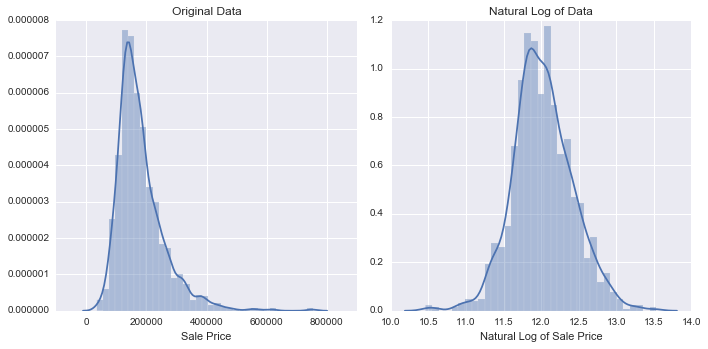

In [3]:
# Examine and remove the skew from the independant variable:

# Load seaborn
import seaborn as sns

# create a backup list to compare
y_nolog = list(data["SalePrice"].values)
data["SalePrice"] =  np.log(y_nolog)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(y_nolog, bins=35)
plt.title('Original Data')
plt.xlabel('Sale Price')

plt.subplot(1,2,2)
sns.distplot(data["SalePrice"], bins=35)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

In [4]:
# Examine Data
print(data.shape) 

# Note: The Error thrown here is due to existence of NaN while calculating stats 
data.describe()

(1460, 81)


/Users/adriel/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,12.024051
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,0.399452
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,10.460242
25%,365.750000,20.000000,NaN,7553.500000,5.000000,5.000000,1954.000000,1967.000000,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,11.775097
50%,730.500000,50.000000,NaN,9478.500000,6.000000,5.000000,1973.000000,1994.000000,NaN,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,12.001505
75%,1095.250000,70.000000,NaN,11601.500000,7.000000,6.000000,2000.000000,2004.000000,NaN,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,12.273731
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,13.534473


There are 78 separate predictors - some with qualitative entries and some with numerical entries. The first attempt will be to try and identify a number of predictors that have a continuous distribution that vary linearly and make linear regression.

##  Linear Regression:

##### Predictors with continuous values:

- LotArea: Lot size in square feet

- LotFrontage: Linear feet of street connected to property

- YearBuilt: Original construction date
- YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
- BsmtUnfSF: Unfinished square feet of basement area
- TotalBsmtSF: Total square feet of basement area

- MasVnrArea: Masonry veneer area in square feet
- 1stFlrSF: First Floor square feet
- 2ndFlrSF: Second floor square feet
- LowQualFinSF: Low quality finished square feet (all floors)

- GrLivArea: Above grade (ground) living area square feet
- GarageArea: Size of garage in square feet
- WoodDeckSF: Wood deck area in square feet
- OpenPorchSF: Open porch area in square feet
- EnclosedPorch: Enclosed porch area in square feet
- 3SsnPorch: Three season porch area in square feet
- ScreenPorch: Screen porch area in square feet
- PoolArea: Pool area in square feet

In [5]:
# Create an array of continuous predictors
ContPredictors = [ "LotArea", "LotFrontage", "YearBuilt", "YearRemodAdd", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", 
                  "GrLivArea", "GarageArea", "MasVnrArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", "PoolArea"]

# Check to see if data needs cleaning
data[ContPredictors].isnull().sum() 

LotArea            0
LotFrontage      259
YearBuilt          0
YearRemodAdd       0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageArea         0
MasVnrArea         8
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
dtype: int64

Two columns need some amount of cleaning: LotFrontage, and MasVnrArea:

- LotFrontage: since there are no 0 values the empty values (NaN) probably were intended as 0 
- MassVnrArea: Only 8 are missing, so we will substitute these with the median. 

In [6]:
# Fill missing values
data["LotFrontage"] = data["LotFrontage"].fillna(0)
data["MasVnrArea"] = data["MasVnrArea"].fillna( data["MasVnrArea"].median())

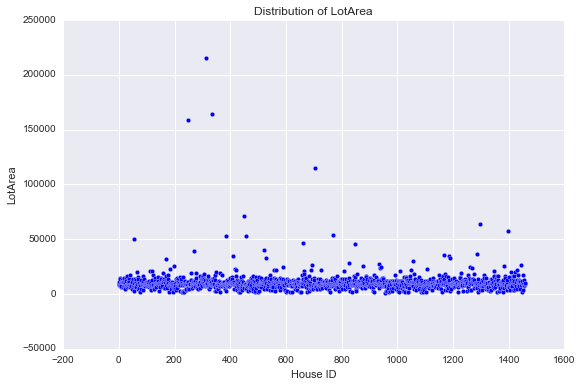

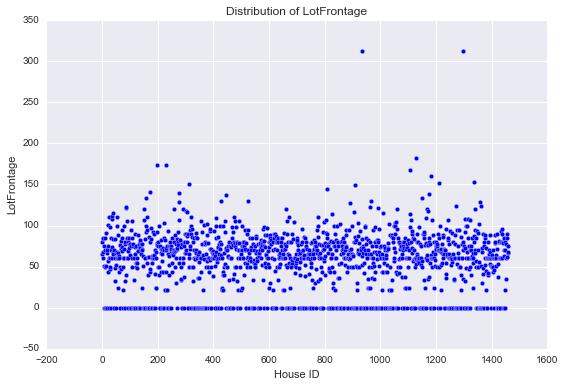

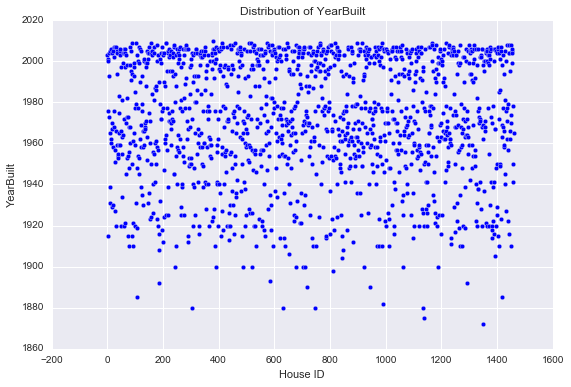

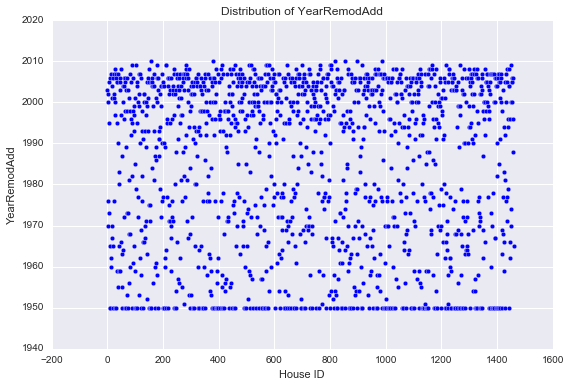

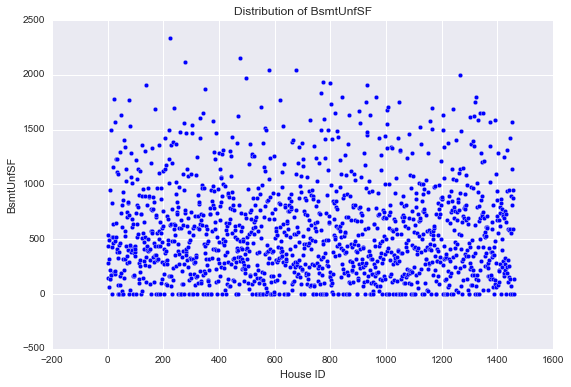

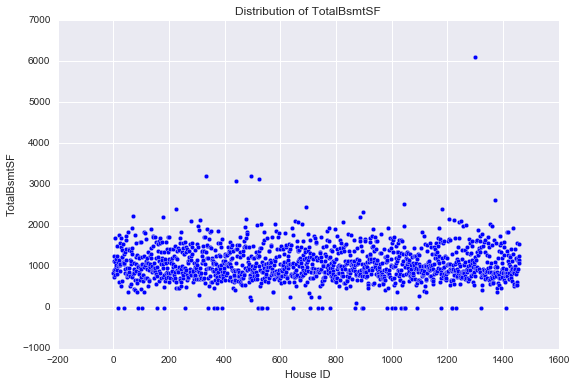

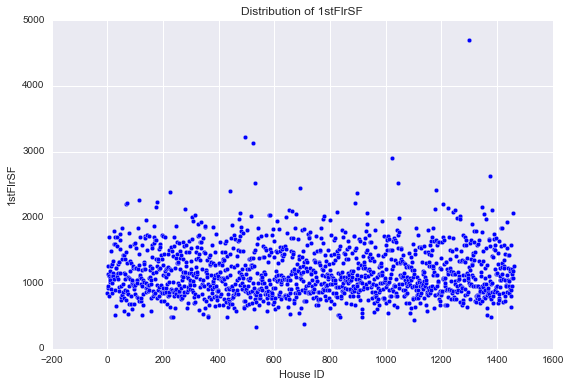

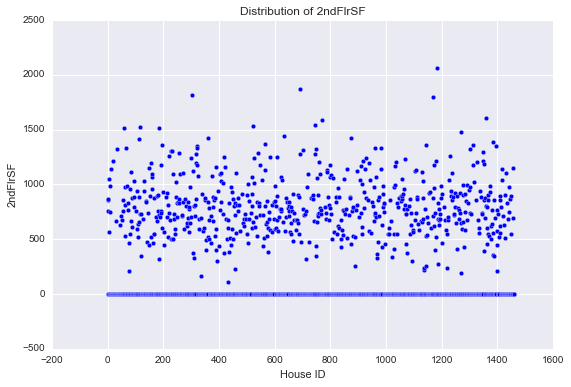

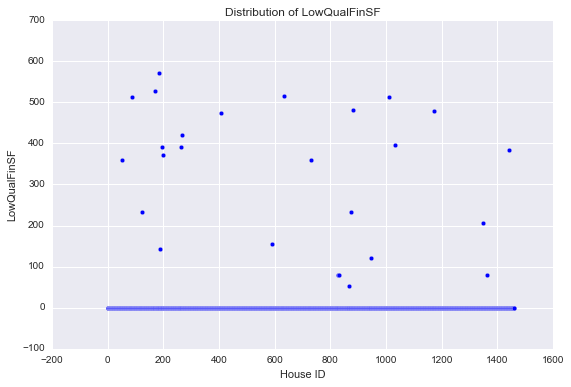

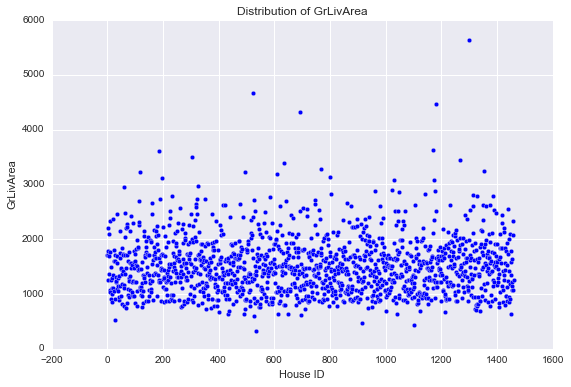

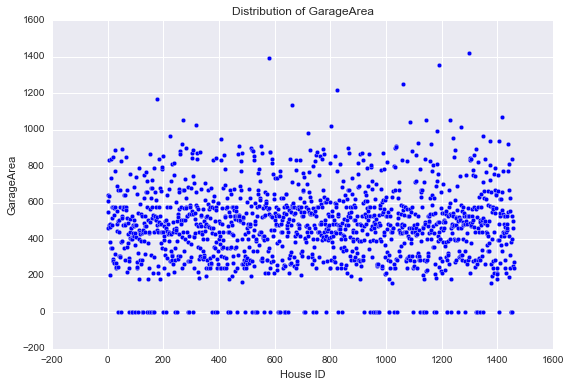

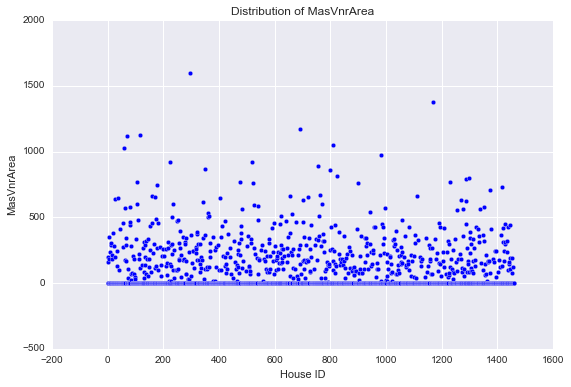

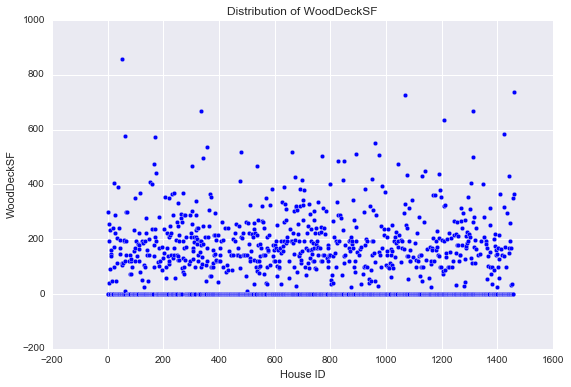

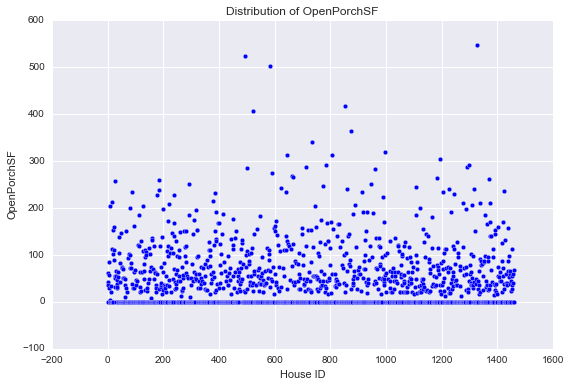

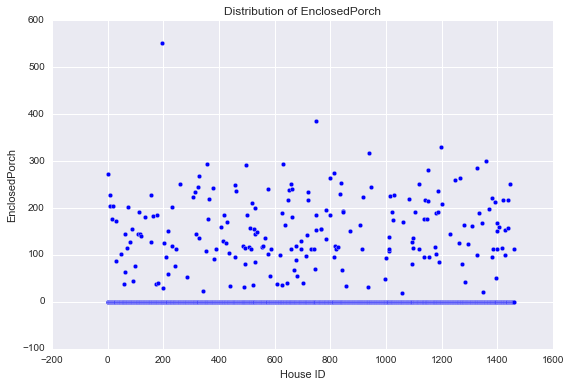

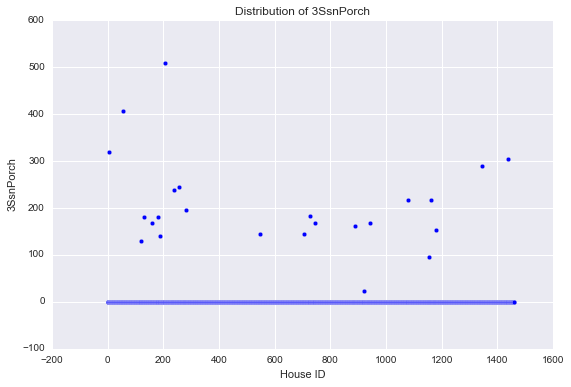

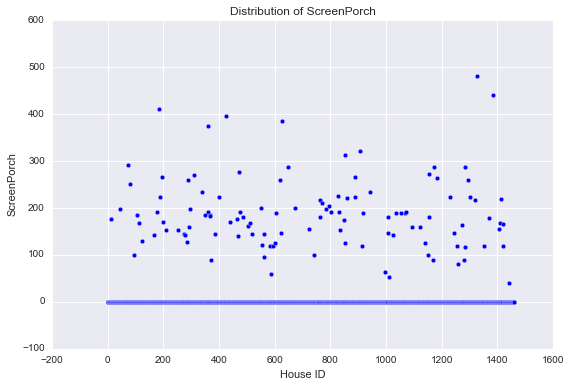

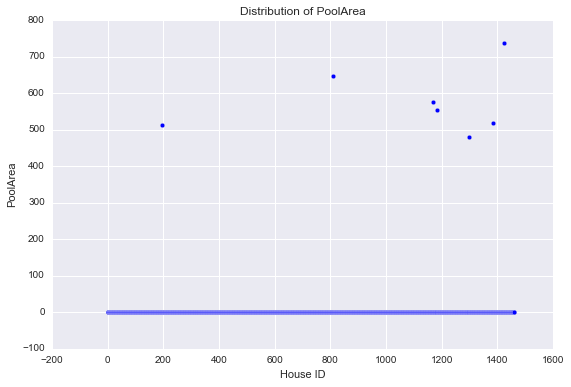

In [7]:
# Make plots to Identify any sparse variables, or variables with large outliers

dflength = data.shape[0]

# Plot:
for variable in ContPredictors:
    plt.scatter( range(dflength), data[variable] )
    plt.xlabel('House ID')
    plt.ylabel(variable)
    plt.title("Distribution of " + variable )
    plt.show()
   

From these plots we can see that the values for LowQualFinSF, 3SsnPorch and PoolArea appear to be almost entirely 0. 
We can verify this and drop them from the predictors we'll use for the linear regression. 


In [8]:
# Calculate the non 0 values. 
print( len( data[ContPredictors].loc[data["LowQualFinSF"] != 0].index ))
print( len( data[ContPredictors].loc[data["3SsnPorch"] != 0].index ))
print( len( data[ContPredictors].loc[data["PoolArea"] != 0].index ))

26
24
7


There are at moset 26 non-zero values, so we will drop these sparse columns as predictors

In [9]:
ContPredictors.remove('LowQualFinSF')
ContPredictors.remove('PoolArea')
ContPredictors.remove('3SsnPorch')

In [10]:
# Make a linear regression model and split the training data into folds for cross validation

from sklearn.linear_model import LinearRegression
from sklearn import cross_validation

# initialize basic LinearRegression Algorithm 
alg = LinearRegression()

# Split the data into 4 train/test divisions
crossval_scores = cross_validation.cross_val_score(alg, data[ContPredictors],data["SalePrice"], cv=4)

# Print scores
print( crossval_scores)
print( crossval_scores.mean())

[ 0.83760579  0.79602206  0.80314417  0.62539387]
0.765541470989


This basic linear algorithm seems to fit with %76.6 accuracy. 

We can try and improve this by examining the linearity of the plots and possibly cleaning the data further. We sill start by examining visually how linear they appear to be:

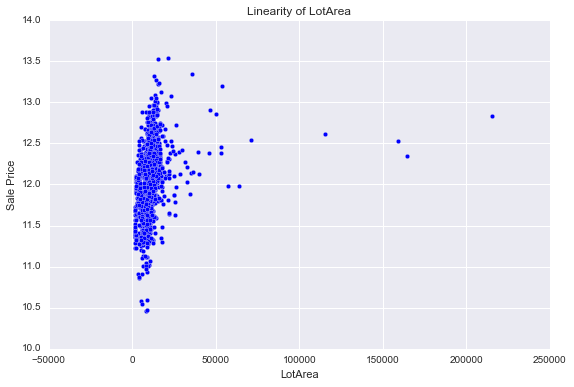

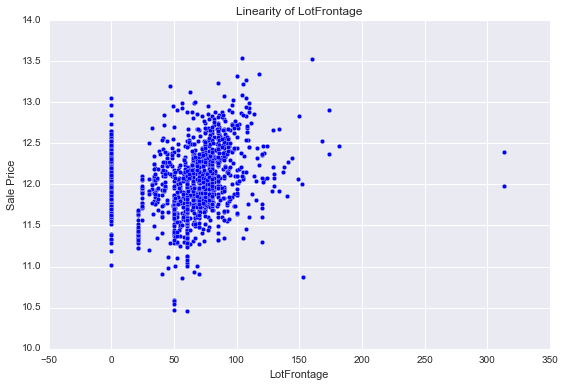

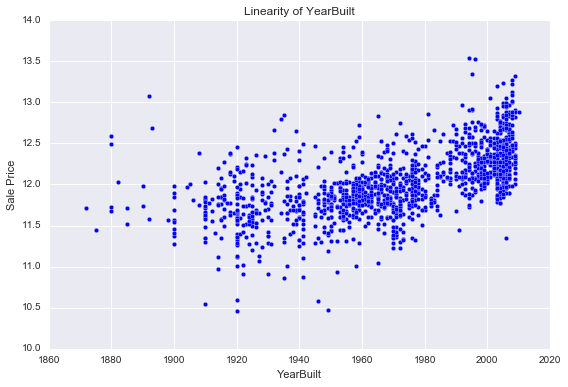

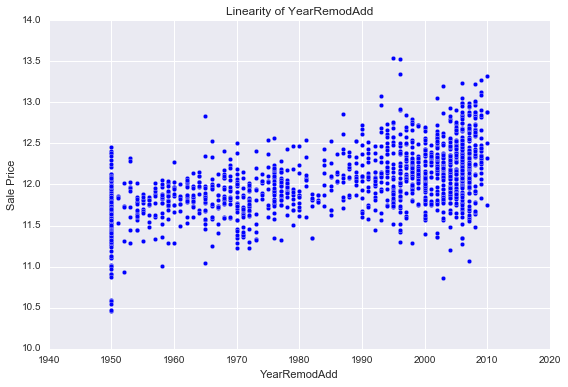

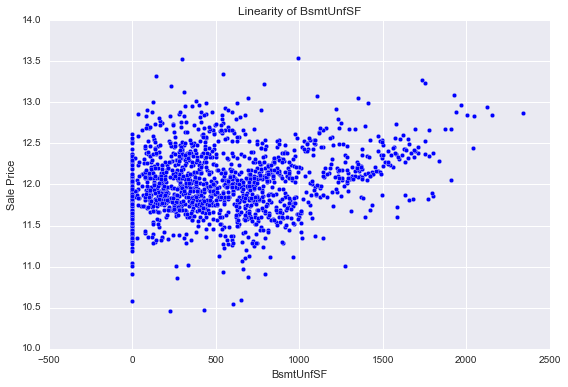

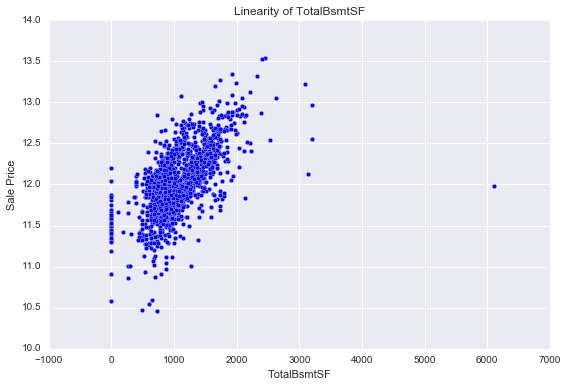

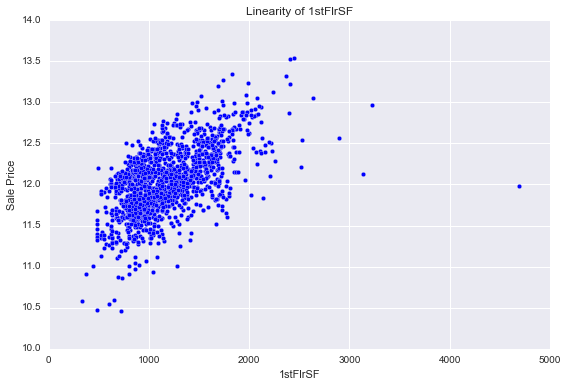

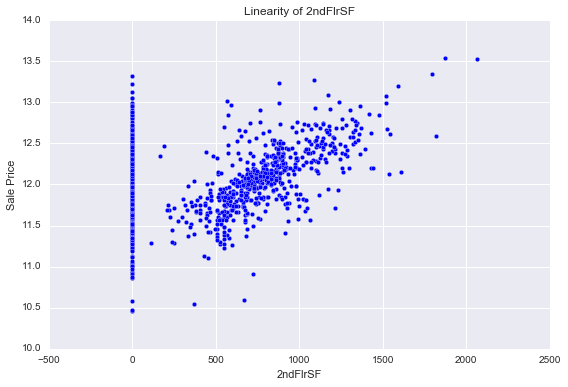

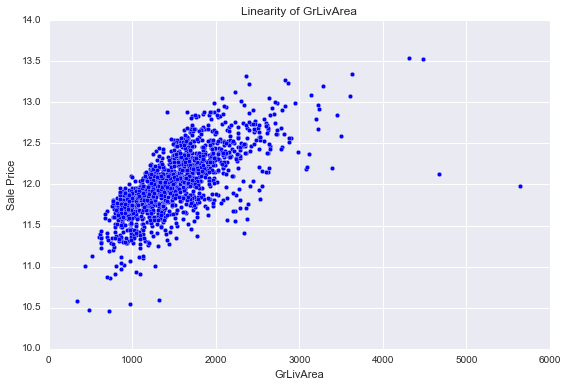

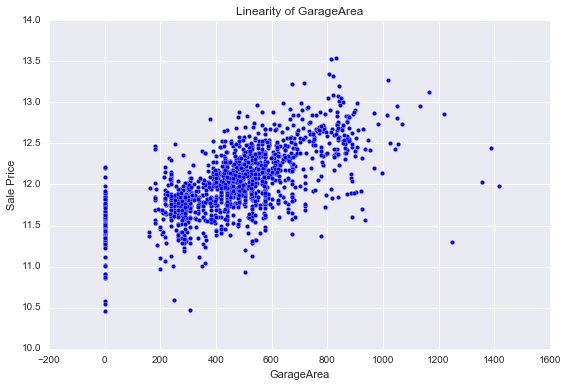

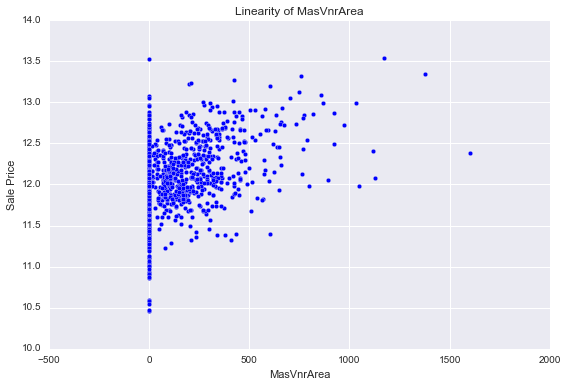

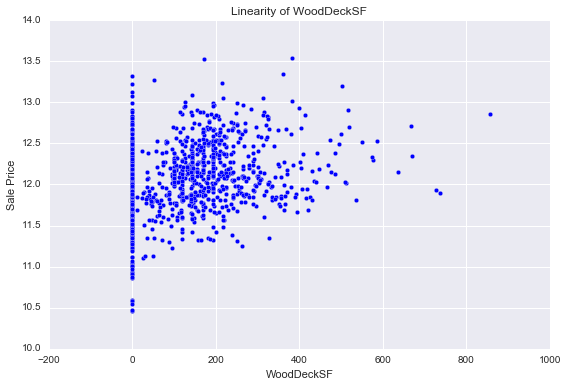

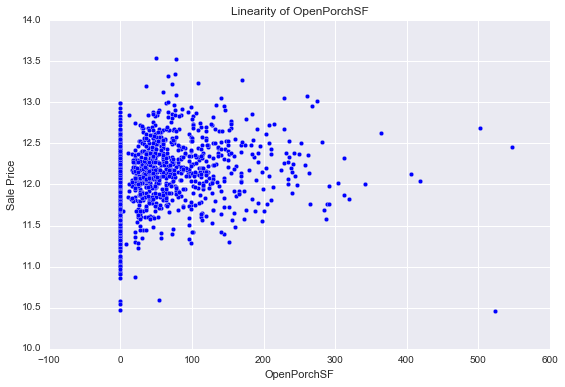

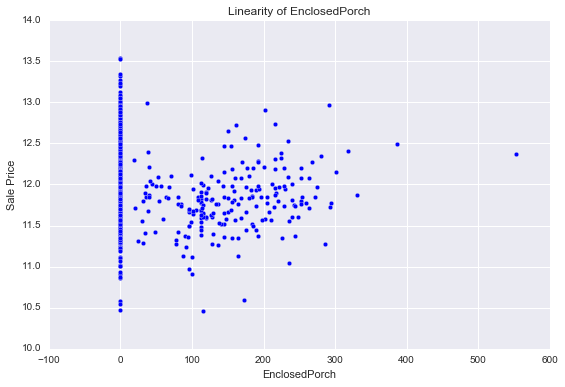

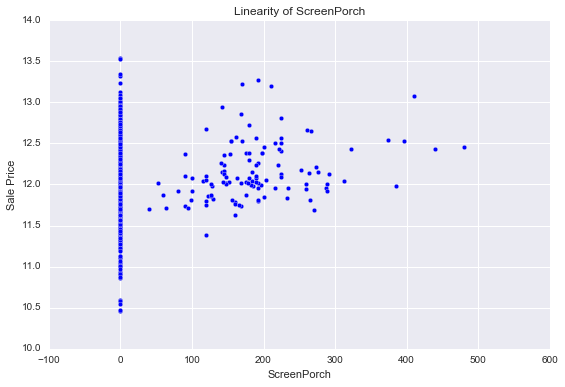

In [11]:
# Plot continuous variables to examine linearity

for variable in ContPredictors:
    plt.scatter( data[variable],data["SalePrice"])
    plt.xlabel(variable)
    plt.ylabel("Sale Price")
    plt.title("Linearity of " + variable )
    plt.show()


It seems like by examining this data we can see two issues: 

some variables dealing with area, such as: LotFrontage, BsmtUnfSF, TotalBsmtSF, 2ndFlrSF, GarageArea, MasVnrArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, and ScreenPorch all show some form of linear response which is skewed by the broad spectrum of prices of houses which do not have this feature (i.e Area of feature = 0) 




From these plots we can see that there are potential large outliers in many of the variables, particularly in:
- LotArea 
- TotalBsmtSF
- 1stFrSF. 

We will deal with the outliers first

### Elimination of outliers: 

create a function to reaplace all data points beyond the nth standard deviation with the median value:

In [12]:
# Create function to reduce outliers. returns an array of cleaned values

# dataset is column of the dataframe 
# n is the number of standard deviations beyond which you wish to set all values to median 
def elim_outliers( dataset, n):
    
    # initialize constants
    data_mean = dataset.mean() 
    data_std = dataset.std()
    data_med = dataset.median()
    
    # create array to hold values
    return_vals = [] 
    
    for value in dataset:    
        if value >= ( data_mean + data_std * n)  or value <= ( data_mean - data_std * n):
            # set return val = data_med
            return_vals.append(data_med)
        else: 
            return_vals.append(value)
            
    return return_vals
        

Values changed from original data:
6


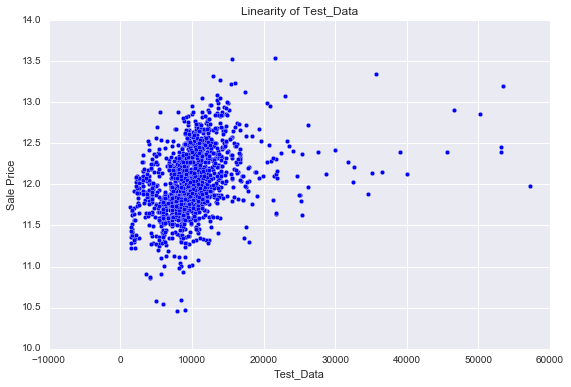

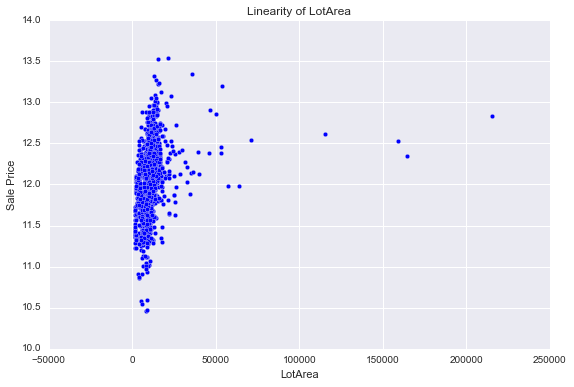

In [13]:
# run function on LotArea as a test to make sure we have desired results

elim_outliers(data.LotArea, 5 )

data["Test_Data"] = elim_outliers(data.LotArea, 5)


# test how many values have changed
print( "Values changed from original data:" )
print( (data["Test_Data"] != data["LotArea"]).sum() )

# plot variables side by side 
testplot = ["Test_Data", "LotArea"]

for variable in testplot:
    plt.scatter( data[variable],data["SalePrice"])
    plt.xlabel(variable)
    plt.ylabel("Sale Price")
    plt.title("Linearity of " + variable )
    plt.show()



This function only modified 6 out of the 1460 values, but dramatically changed scale of graph showing the data is less linear than might appear

In [14]:
# apply this function to the data and see if we can predict better than %72 with a regression

for variable in ContPredictors:
       data[variable] = elim_outliers(data[variable], 5 )
    

In [15]:
crossval_scores_2 = cross_validation.cross_val_score(alg, data[ContPredictors], data["SalePrice"], cv=4)
print( crossval_scores_2)
print( crossval_scores_2.mean())

[ 0.84426438  0.82329486  0.8293899   0.81705026]
0.828499847393


By cleaning the outliers, our linear regression fit when from %76.6, to %82.8 accuracy

In [16]:
# Fit the linear regression funciton on the outlier removed data 
alg.fit( data[ContPredictors], data["SalePrice"] )


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Cleaning Data by separating x = 0 data pre-fit:

It seems like some variables dealing with area, such as: LotFrontage, BsmtUnfSF, TotalBsmtSF, 2ndFlrSF, GarageArea, MasVnrArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, and ScreenPorch, all show some form of linear response that is skewed by the broad spectrum of prices of houses which do not have this feature. We will make function to see if we can provide a more accurate fit. 

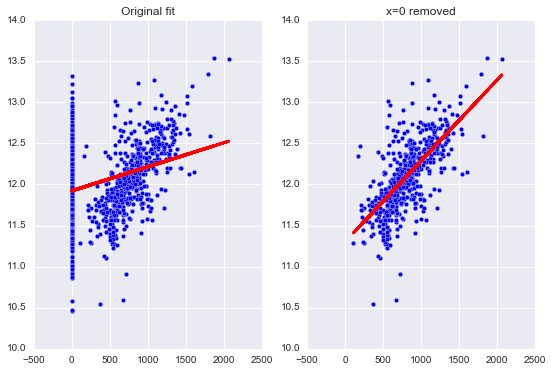

Fit score for original:
0.0995644871761


Fit score for mean x=0 removed:
0.462375496972


In [17]:
# make new data set to fit which omits all entries with 0 

fitdata = data[["2ndFlrSF", "SalePrice"]]

# find where all values are 0 
mean_for_0 = fitdata.loc[fitdata['2ndFlrSF'] == 0].mean()

# Create a table where the 0 value rows are dropped. 
fitdata_clean = fitdata[fitdata['2ndFlrSF'] != 0 ]

# alg_u used to compare with uncleaned data
alg_u = LinearRegression()

# alg_c used for clean data
alg_c = LinearRegression()

# reshape data for fitting
# uncleaned
x_u = fitdata['2ndFlrSF'].reshape(-1,1)
y_u = fitdata['SalePrice'].reshape(-1,1)

# cleaned
x_c = fitdata_clean['2ndFlrSF'].reshape(-1,1)
y_c = fitdata_clean['SalePrice'].reshape(-1,1)

# uncleaned
crossval_scores_u = cross_validation.cross_val_score(alg_u, x_u, y_u, cv=3)

# cleaned
crossval_scores_c = cross_validation.cross_val_score(alg_c, x_c, y_c, cv=3)

# fit algs: 
alg_c.fit( x_c, y_c )
alg_u.fit( x_u, y_u )

# Plot comparison of cleaned vs uncleaned
# Plot cleaned: 
fig = plt.figure()

sub1 = fig.add_subplot(1, 2, 2)
sub1.scatter( fitdata_clean["2ndFlrSF"], fitdata_clean["SalePrice"] )
sub1.set_title("x=0 removed")
sub1.plot(x_c, alg_c.predict(x_c), color='red',
         linewidth=3)

# Plot uncleaned
sub2 = fig.add_subplot(1, 2, 1, sharex= sub1, sharey= sub1)
sub2.scatter( fitdata["2ndFlrSF"], fitdata["SalePrice"] )
sub2.set_title("Original fit")
sub2.plot(x_u, alg_u.predict(x_u), color='red',
         linewidth=3)

#fig.tight_layout()
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

plt.show()

print( "Fit score for original:")
print( crossval_scores_u.mean())
print("\n")
print( "Fit score for mean x=0 removed:")
print( crossval_scores_c.mean())



Now that the method works we will apply it to the rest of our dataset

Before altering the dataset we will first create columns of boolean values. For some columns perhaps it is more important that a feature simply exists rather than the exact value. We can use the updated predictor columns in our linear regression and in our random forest model which we will build. 

In [18]:
# Only remove x = 0 vals from necessary parameters
# We will make boolan columns of these same values
params_to_clean = [ "LotFrontage", "BsmtUnfSF", "TotalBsmtSF", "2ndFlrSF", "GarageArea", "MasVnrArea", "WoodDeckSF"]

In [19]:
# function to create binary columns for existence of a feature

def data_booleans(dataset, parameters) : 

    # create new dataframe that we will append booleans to
    return_df = dataset.copy()
    # Create an array to store ALL predictors, boolean and original
    newparameters = ContPredictors.copy()
    
    for parameter in parameters: 
        # make a new boolean parameter name: 
        new_param_name = parameter + "_YN"
        
        # add to our final list of predictors
        newparameters.append(new_param_name)
        
        # create a new column of booleans for existence of that parameter
        return_df[new_param_name] = dataset.ix[:, parameter]
        return_df[new_param_name] = return_df[new_param_name].apply(lambda x: 1 if (x != 0) else 0 )
        
    return return_df, newparameters

# Apply this funciton on our data set 
data, BooleanPredictors = data_booleans(data, params_to_clean)



Now, to apply the x=0 correction to our data set, we need a helper function which fits the function, replaces the values at x=0 with the value predicted by the fit function (we can't simply delete these data because all matrices must have the same size, so we will simply replace it by the fit value so that we get the same fit) 

In [20]:
# Helper function that predicts the X position of a linear fit based on thedata["SalePrice"]value (inverse operation to .predict())
# alg is a linear algorith that's already been fit. 

def x_predict(y, alg):
    slope = alg.coef_[0][0]
    intercept = alg.predict(0)[0][0]
    return (y - intercept) / slope


In [21]:
# parameters  = parameters to remove x = 0 values for
# dataset = original dataset to select parameters from
# response =data["SalePrice"]variable

def xcleaner(dataset, parameters, response) : 

    # create new dataframe
    return_df = dataset.copy()
    # create dicttionary to hold the scores
    fitscores = {}
    
    for parameter in parameters: 

        # make new data set to fit which omits all entries with 0 

        # new dataframe
        new_df = dataset[[parameter, response]]

        # Create a table where the 0 value rows are dropped. 
        new_df_clean = new_df.loc[new_df[parameter] != 0]
        
        # Initialize linear algorithm used for clean data
        alg_c = LinearRegression()

        # cleaned
        x_c = new_df_clean[parameter].reshape(-1,1)
        y_c = new_df_clean[response].reshape(-1,1)

        # cleaned fit scores
        fitscores[parameter] = cross_validation.cross_val_score(alg_c, x_c, y_c, cv=3).mean() 
        
        # fit algorithm: 
        alg_c.fit( x_c, y_c )
        
        # Reinsert fit values for x = 0
        for i in range(len( return_df[parameter])):
            if return_df.loc[i, parameter] == 0:
                return_df.loc[i, parameter] = x_predict(return_df.loc[i, "SalePrice"], alg_c)
        
    return return_df, fitscores
        

Now apply this funciton to the parameters:

In [22]:
# x = 0  cleaned dataset
data, fitscores = xcleaner(data, params_to_clean, "SalePrice")


now we create and fit new linear regression on the modified data set: 

In [23]:
# initialize basic LinearRegression Algorithm 
linalg_xcleaned = LinearRegression()

# Get scores of train/tests
crossval_scores = cross_validation.cross_val_score(linalg_xcleaned, data[ContPredictors], data["SalePrice"], cv=4)

print( crossval_scores.mean())

0.904472239877


The fit score is quite high, which should be expected as we used the previous fit to replace the data

In [24]:
# Fit the algorithm so we use it on the test set
linalg_xcleaned.fit(data[ContPredictors], data["SalePrice"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
# Test all predictors, even binary predictors
# initialize basic LinearRegression Algorithm 
linalg_xcleaned_binary = LinearRegression()

# compute fit scores
crossval_scores = cross_validation.cross_val_score(linalg_xcleaned_binary, data[BooleanPredictors], data["SalePrice"], cv=4)

# print( crossval_scores)
print( crossval_scores.mean())

0.906363643428


The fit score does not change when adding the boolean variables in the linear regression, so we will only use these new boolean values for the Random Forest

## DECISION TREES AND RANDOM FORESTS: 
In this section I will use decision trees / random forest algorithms to make a predicition model for the class based predictors. I'll compare this with the regression from the previous sections.

In the same way as before, I will look for predictors that have descrete/class values: 

TYPE OF BUILDING: 

- MSSubClass: Identifies the type of dwelling involved in the sale.
- BldgType: Type of dwelling
- HouseStyle: Style of dwelling
- OverallQual: Rates the overall material and finish of the house
- OverallCond: Rates the overall condition of the house


FEATURES:

- Heating: Type of heating
- HeatingQC: Heating quality and condition
- CentralAir: Central air conditioning
- Electrical: Electrical system
- RoofStyle: Type of roof
- RoofMatl: Roof material
- Exterior1st: Exterior covering on house
- Exterior2nd: Exterior covering on house (if more than one material)
- MasVnrType: Masonry veneer type
- ExterQual: Evaluates the quality of the material on the exterior 
- ExterCond: Evaluates the present condition of the material on the exterior
- Foundation: Type of foundation
- PoolQC: Pool quality
- Fence: Fence quality
- PavedDrive: Paved driveway
- GarageCond: Garage condition
- GarageQual: Garage quality
- GarageFinish: Interior finish of the garage
- Fireplaces: Number of fireplaces
- Functional: Home functionality (Assume typical unless deductions are warranted)
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
- KitchenQual: Kitchen quality
- FullBath: Full bathrooms above grade
- HalfBath: Half baths above grade
- Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
- Kitchen: Kitchens above grade
- FireplaceQu: Fireplace quality
- GarageType: Garage location


SURROUNDINGS: 

- Neighborhood: Physical locations within Ames city limits
- Condition1: Proximity to various conditions
- Condition2: Proximity to various conditions (if more than one is present)
- MiscFeature: Miscellaneous feature not covered in other categories
- MSZoning: Identifies the general zoning classification of the sale.
- Street: Type of road access to property
- Alley: Type of alley access to property
- LotShape: General shape of property
- LandContour: Flatness of the property
- Utilities: Type of utilities available
- LotConfig: Lot configuration
- LandSlope: Slope of property


BASEMENT: 

- BsmtFullBath: Basement full bathrooms
- BsmtHalfBath: Basement half bathrooms
- BsmtFinType2: Rating of basement finished area (if multiple types)
- BsmtFinType1: Rating of basement finished area
- BsmtExposure: Refers to walkout or garden level walls
- BsmtCond: Evaluates the general condition of the basement
- BsmtQual: Evaluates the height of the basement

TYPE OF SALE

- SaleCondition: Condition of sale
- SaleType: Type of sale


In [26]:
# Create the predictor array

DiscretePredictors = [
'BldgType','HouseStyle','OverallQual','OverallCond','Heating','HeatingQC','Electrical','RoofStyle','CentralAir','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
'ExterQual','ExterCond','Foundation','PoolQC','Fence','PavedDrive','GarageCond','GarageQual','GarageFinish','Fireplaces',
'Functional','TotRmsAbvGrd','KitchenQual','Neighborhood','Condition1','Condition2','MiscFeature','MSZoning','Street',
'Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','BsmtFullBath','BsmtHalfBath','BsmtFinType2',
'BsmtFinType1','BsmtExposure','BsmtCond','BsmtQual','FullBath','HalfBath','FireplaceQu',
'GarageType','SaleCondition','SaleType' ]


# To these predictors we can add the boolean values we created:
Booleanparams = ['LotFrontage_YN','BsmtUnfSF_YN','TotalBsmtSF_YN','2ndFlrSF_YN','GarageArea_YN','MasVnrArea_YN','WoodDeckSF_YN']

AllDiscretePredictors = DiscretePredictors +  Booleanparams

    


In [27]:
# Examine what types of entries these predictors have

for parameter in DiscretePredictors:
    print( parameter, end=" : ")  
    print( data[parameter].unique() ) 

BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
OverallQual : [ 7  6  8  5  9  4 10  3  1  2]
OverallCond : [5 8 6 7 4 2 3 9 1]
Heating : ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
HeatingQC : ['Ex' 'Gd' 'TA' 'Fa' 'Po']
Electrical : ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
CentralAir : ['Y' 'N']
RoofMatl : ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll' 'ClyTile']
Exterior1st : ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
Exterior2nd : ['VinylSd' 'MetalSd' 'Wd Shng' 'HdBoard' 'Plywood' 'Wd Sdng' 'CmentBd'
 'BrkFace' 'Stucco' 'AsbShng' 'Brk Cmn' 'ImStucc' 'AsphShn' 'Stone' 'Other'
 'CBlock']
MasVnrType : ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
ExterQual : ['Gd' 'TA' 'Ex' 'Fa']
ExterCond : ['TA' 'Gd' 'Fa' 'Po' 

We need to turn all of these different class based entries into integers that the random forest algorithm can handle. We will do that with the following function:

In [28]:
# Batch process these parameters
# dataset is a dataframe to modify

def discretizer(dataset):
    for parameter in DiscretePredictors:

        keymap ={}
        keymap.clear()
        
        # maps the ith unique entry to the value i
        for i in range(len(dataset[parameter].unique())):
            keymap[dataset[parameter].unique()[i]] = i

        
        dataset[parameter] = dataset[parameter].map(keymap)

In [29]:
# apply this function to our dataset
discretizer(data)

# Trust, but verify
data[DiscretePredictors].head()



,BldgType,HouseStyle,OverallQual,OverallCond,Heating,HeatingQC,Electrical,RoofStyle,CentralAir,RoofMatl,...,BsmtFinType1,BsmtExposure,BsmtCond,BsmtQual,FullBath,HalfBath,FireplaceQu,GarageType,SaleCondition,SaleType
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,0,0,0,0,0,0,...,1,1,0,0,0,1,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,1,1,1,1,2,1,1,0
4,0,0,2,0,0,0,0,0,0,0,...,0,3,0,0,0,0,1,0,0,0


Now that we have a list of many predictors, we can test to see which correlate most strongly with the response variable, and see if selecting only those will imrove the fit

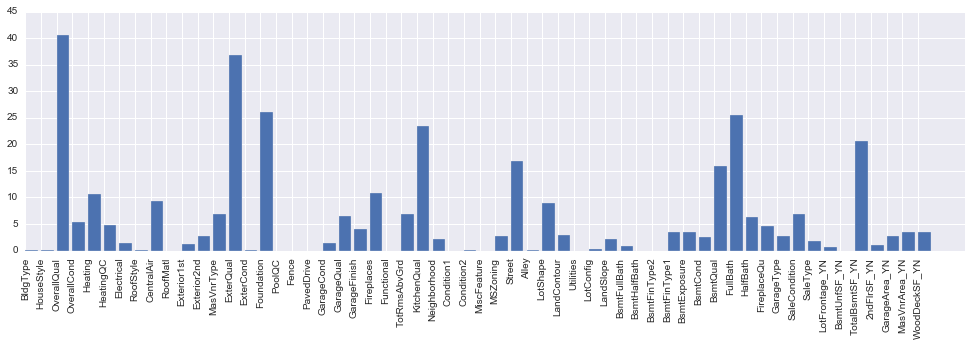

In [30]:
from sklearn.feature_selection import SelectKBest, f_classif

# Perform feature selection

# f_classif is the method of measuring variance, could also be chi2
selector = SelectKBest(f_classif, k=5)
selector.fit(data[AllDiscretePredictors], data["SalePrice"])

# because all p values are small we will take the -log
scores = -np.log10(selector.pvalues_)

# Make a bar plot 
plt.figure()
plt.figure(figsize=(15,4))
# plots scores by making as many divs as predictors
plt.bar(range(len(scores)), scores)

# Mark the x axis 
plt.xticks(range(len(AllDiscretePredictors)), AllDiscretePredictors, rotation= "vertical")
plt.show()



In [31]:
# From this it seems the qualities that make the greatest difference are:
  
TopDiscretePredictors = [ 'OverallQual', 'ExterQual', 'Foundation', 'FullBath', 'KitchenQual' , 'BsmtQual', 'Street', 'BsmtQual', 'TotalBsmtSF_YN']

In [32]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor

# Initialize our Random Forest Algorithms and compare All predictors vs just the top predictors
# n_estimators is the number of trees we want to make
# min_samples_split is the minimum number of rows we need to make a split
# min_samples_leaf is the minimum number of samples we can have at the place where a tree branch ends (the bottom points of the tree)

RndFor_alg = RandomForestRegressor(random_state=1, n_estimators=200, min_samples_split=10, min_samples_leaf=1)

# All discrete parameters:
# Split the data into 3 folds
kf = cross_validation.KFold(data[AllDiscretePredictors].shape[0], n_folds=3)

# score the fit
scores = cross_validation.cross_val_score(RndFor_alg, data[AllDiscretePredictors], data['SalePrice'], cv= kf)

# print scores
print( "Rnd Forest fit score for All discrete parameters: ", end = "")
print(scores.mean())

# Top discete parameters
# Split the data into 3 folds
kf = cross_validation.KFold(data[TopDiscretePredictors].shape[0], n_folds=3)

# score the fit
scores = cross_validation.cross_val_score(RndFor_alg, data[TopDiscretePredictors], data['SalePrice'], cv= kf)

# print scores
print( "Rnd Forest fit score for Top discrete parameters: ", end = "")
print(scores.mean())


Rnd Forest fit score for All discrete parameters: 0.789547673331
Rnd Forest fit score for Top discrete parameters: 0.690309466714


Using only the top predictors actually decreases the fit score. We will use all the parameters (though this caries a greater risk of overfitting for implicit variables - to determine if this is the case we would need to check covariance between variables) 

In [33]:
RndFor_alg.fit(data[AllDiscretePredictors], data['SalePrice'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

Another thing we can try is to apply a random forest model to the continous predictors as well: 

In [34]:
# All cont on uncleaned

randfor_cont = RandomForestRegressor(random_state=1, n_estimators=150, min_samples_split=5, min_samples_leaf=2)

kf = cross_validation.KFold(data[ContPredictors].shape[0], n_folds=3)

scores = cross_validation.cross_val_score(randfor_cont, data[ContPredictors], data['SalePrice'], cv= kf)

print( "Rnd Forest Fit score for all continuous parameters: ", end = "")
print( scores.mean())

randfor_cont.fit(data[ContPredictors], data["SalePrice"] )

Rnd Forest Fit score for all continuous parameters: 0.937411616828


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=2,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

This algorithm actually preforms fairly well, so we will use it as one of the algorithms included in the ensemble

## Creating the submission file for Kaggle: 

Now we must perform all of the same manipulations to the test set as we performed on the training set:

In [35]:
# Submitting to Kaggle to check the effectiveness

# Load the testing data provided by Kaggle
test_df = pd.read_csv("/Users/adriel/code/DataScience/Datasets/House_Prices/test.csv")

# Clean the data and fill missing values as we did in our training set
test_df["LotFrontage"] = test_df["LotFrontage"].fillna(0)
test_df["MasVnrArea"] = test_df["MasVnrArea"].fillna( test_df["MasVnrArea"].median())

# a few more sparse missing points exist in this set so we loop to catch all
for parameter in ContPredictors:
    test_df[parameter] = test_df[parameter].fillna( test_df[parameter].median())    
    
# Remove Outliers
for variable in ContPredictors: 
    test_df[variable] = elim_outliers(test_df[variable], 5 )

# Process the discrete predictors
discretizer(test_df)
    
# Create Booleans 
test_df, BooleanPredictors = data_booleans(test_df, params_to_clean)

# fill few sparse remaining errors
test_df[DiscretePredictors] = test_df[DiscretePredictors].fillna(0)

# verify we achieve what we expect 
test_df.head()
 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,YrSold,SaleType,SaleCondition,LotFrontage_YN,BsmtUnfSF_YN,TotalBsmtSF_YN,2ndFlrSF_YN,GarageArea_YN,MasVnrArea_YN,WoodDeckSF_YN
0,1461,20,0,80.0,11622.0,0,0,0,0,0,...,2010,0,0,1,1,1,0,1,0,1
1,1462,20,1,81.0,14267.0,0,0,1,0,0,...,2010,0,0,1,1,1,0,1,1,1
2,1463,60,1,74.0,13830.0,0,0,1,0,0,...,2010,0,0,1,1,1,1,1,0,1
3,1464,60,1,78.0,9978.0,0,0,1,0,0,...,2010,0,0,1,1,1,1,1,1,1
4,1465,120,1,43.0,5005.0,0,0,1,1,0,...,2010,0,0,1,1,1,0,1,0,0


Now we fit the three algorithms which performed the best, and use the average of their scores as the final sale price. Ensembling different types of algorithms may help reduce the bias that any single type may have on its own.

In [36]:
# Algorithms have already been fit
algorithms = [[linalg_xcleaned, ContPredictors],[RndFor_alg, AllDiscretePredictors], [randfor_cont, ContPredictors]]

full_predictions = []
for alg, predictors in algorithms:
    
    # Predict using the test dataset.  We have to convert all the columns to floats to avoid an error.
    predictions = alg.predict(test_df[predictors]) #[:,1]
    full_predictions.append(predictions)

# Average the three predictions
predictions = (full_predictions[0] + full_predictions[1] + full_predictions[2]) / 3


# Apply the inverse log so we have SalePrice on the same scale for verification
predictions_scaled = np.exp(predictions)

In [37]:
# create the submission file for Kaggle
submission = pd.DataFrame({
        "Id": range(1461,2920),
        "SalePrice": predictions_scaled
    })

submission.to_csv("ensebled_predictions", index=False)

## Conclusions:


This basic model acheives a score of roughly ~0.3 depending on the parametes (top score is ~ 0.01). After testing several submissions I realized that my function to redistribute x = 0 data was decreasing the score. I believe this occured because I am overfitting the training data but my next steps will be to unpack this function and see if this is what is happening. Perhaps rescaling the x values I reinsert will provide a better result.

Ideas to further improve this submission: 

- Combine the test and train dataframes into a single set for analysis statistics since they are roughly equal size. This will not work to fit the models, obviously, but it may help with deciding on how to replace the class values, and missing values. 

- Polynomial /exp fits to predictors, not simply linear.
    
- parameter sweeps to tune the fits (i.e min_samples_split)
 
I made a lot of changes to this code as I went along - changeing how the funcitons worked, what arguments they take, whether they copy or modify the input data. I'm still not sure what the best way of writing modular code for datascience is, so I would like to improve on this next.